<p style="font-size:30px"><b>Spam Data Analysis<b></p>
    

This project uses Naive Bayes classifier to differentiate between spam and ham emails.
The dataset used was obtained from kaggle.com.
The purpose of this project is to understand the implementation of naive bayes in text mining.

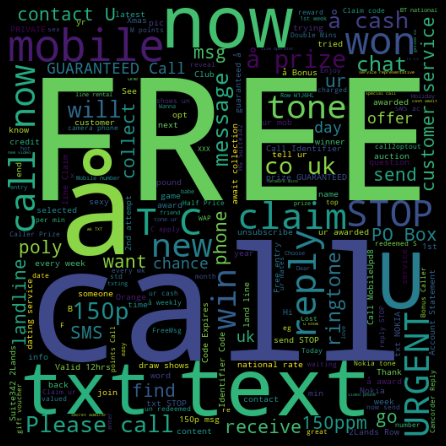

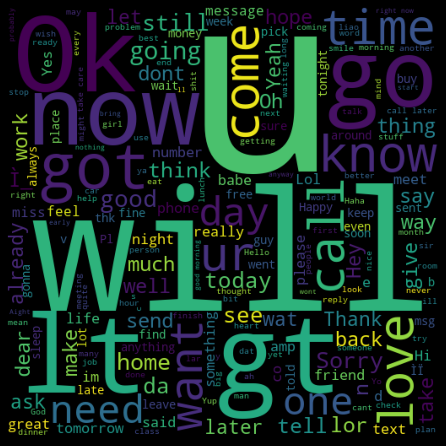

Input text: hello this is test message
No Spam Detected


In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline


mails = pd.read_csv('spam.csv', encoding = 'latin-1')
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mails.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
mails['label'] = mails['labels'].map({'ham': 0, 'spam': 1})
mails.drop(['labels'], axis = 1, inplace = True)

trainIndex = list()
for i in range(mails.shape[0]):
    trainIndex += [i]

trainData = mails.loc[trainIndex]

spam_words = ' '.join(list(mails[mails['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (6,6), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

ham_words = ' '.join(list(mails[mails['label'] == 0]['message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (6,6), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#Preprocess message
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 0:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]  
    return words

class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['label']#load traindata
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()

    

    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        
        #identify spam and ham from traindata
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        
        #Initialize
        self.total_mails = self.spam_mails + self.ham_mails
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i]) #tokenize, remove stopwords and stemming the traindata
            
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF(Inverse Document Frequency)
            for word in message_processed:#check each word of single traindata email for 1 or 0
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1 #count of Spam words
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1 #count of Ham words 
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        
        #Calculate probability of spam words using tf-idf
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]        
        for word in self.tf_spam:            
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        #Calculate probability of Ham words using tf-idf    
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails         

    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        
        for word in processed_message:                
            if word in self.prob_spam: # check prob for each ham and spam word and detect spam if pSpam >= pHam
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys()))) #remove IDF from pSpam
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) #remove IDF from pHam
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
sc_tf_idf = SpamClassifier(trainData, 'tf-idf')
sc_tf_idf.train()

message='hello this is test message'
pm=process_message(message)
if(sc_tf_idf.classify(pm)):
    print("Input text: " + message)
    print("Spam Detected")
else:
    print("Input text: " + message)
    print("No Spam Detected")